In [ ]:
% cd /content/drive/MyDrive/DS-Project/datasets

/content/drive/MyDrive/DS-Project/datasets


# Loading libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import copy
from IPython.display import clear_output

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


# Preprocessing and Data Loading

In [ ]:
SPECIAL_TOKENS = {
    '<PAD>': 0,     # Padding token - to equalize size of expressions
}

"""
To create lookup tables for vocabulary
"""
def lookup_table(vocabulary):
    """
    vocabulary: String of all characters of a particular language
    """
    vocabulary = set(list(vocabulary))
    v2i = copy.copy(SPECIAL_TOKENS)
    for i, vocab in enumerate(vocabulary, len(SPECIAL_TOKENS)):
        v2i[vocab] = i

    i2v = {i:v for v, i in v2i.items()}
    return v2i, i2v

ENG = 'abcdefghijklmnopqrstuvwxyz'
HIN = ''.join(c for c in [chr(alpha) for alpha in range(2304, 2432)])

hin_v2i, hin_i2v = lookup_table(HIN)
eng_v2i, eng_i2v = lookup_table(ENG)

In [ ]:
print(eng_v2i)
print(hin_v2i)

{'<PAD>': 0, 'w': 1, 'l': 2, 'n': 3, 'g': 4, 'a': 5, 'q': 6, 'x': 7, 'b': 8, 'c': 9, 'd': 10, 'o': 11, 'j': 12, 't': 13, 'v': 14, 'p': 15, 'k': 16, 's': 17, 'z': 18, 'f': 19, 'i': 20, 'u': 21, 'y': 22, 'h': 23, 'r': 24, 'm': 25, 'e': 26}
{'<PAD>': 0, 'ण': 1, 'ओ': 2, 'द': 3, 'ग़': 4, 'ऄ': 5, 'ॖ': 6, 'ऊ': 7, '॰': 8, 'ॡ': 9, 'ॺ': 10, '़': 11, 'ॆ': 12, 'े': 13, 'ख': 14, '८': 15, 'क़': 16, 'ह': 17, 'त': 18, 'ॉ': 19, 'ळ': 20, 'औ': 21, 'ए': 22, 'ज': 23, 'ग': 24, '॔': 25, 'य': 26, 'ै': 27, '०': 28, 'ं': 29, 'ॷ': 30, 'ऽ': 31, 'ल': 32, 'ौ': 33, 'छ': 34, 'ि': 35, 'ॊ': 36, 'ॼ': 37, 'ऀ': 38, 'ॵ': 39, '।': 40, 'ॲ': 41, 'फ़': 42, 'ऴ': 43, 'ऻ': 44, 'ऑ': 45, '१': 46, 'थ': 47, 'ॹ': 48, 'ऩ': 49, 'ॎ': 50, '७': 51, 'ॕ': 52, 'ठ': 53, 'ॸ': 54, 'ॐ': 55, 'ऐ': 56, 'ऺ': 57, 'अ': 58, 'आ': 59, 'ु': 60, '॑': 61, 'ॏ': 62, 'ई': 63, 'प': 64, '॓': 65, '॥': 66, 'म': 67, 'ऒ': 68, 'ॳ': 69, 'ढ': 70, 'ॾ': 71, '६': 72, 'ॄ': 73, 'ॽ': 74, 'ऱ': 75, 'ी': 76, '४': 77, 'ञ': 78, 'ऋ': 79, 'ट': 80, 'ू': 81, 'ॿ': 82, 'ः': 83, 'घ': 84, 'ड

In [ ]:
# We don't need to clean the dataset as the dataset is already cleaned
dataset = pd.read_csv('transliteration.txt', delimiter='\t', encoding='utf-8', na_filter=False, header=None)
print(dataset.shape)
ENG_WORDS = dataset.iloc[:, 0].to_numpy()
HIN_WORDS = dataset.iloc[:, 1].to_numpy()
print(ENG_WORDS[342], HIN_WORDS[342])
HIN_TRAIN, HIN_TEST, ENG_TRAIN, ENG_TEST = train_test_split(HIN_WORDS, ENG_WORDS, test_size=0.15)
print(len(HIN_TRAIN), len(HIN_TEST))

(30823, 2)
raha रह
26199 4624


In [ ]:
class DataLoader(Dataset):
  def __init__(self, english, hindi):
    self.eng_words = english
    self.hin_words = hindi
    self.shuffle_indices = list(range(len(self.hin_words)))
    self.shuffle_start_idx = 0
    random.shuffle(self.shuffle_indices)

  def __len__(self):
    return len(self.hin_words)

  def __getitem__(self, idx):
    return self.hin_words[idx], self.eng_words[idx]

  def get_random_sample(self):
    return self.__getitem__(np.random.randint(len(self.hin_words)))

  def get_array_batch(self, BATCH_SIZE, arr):
    end = self.shuffle_start_idx + BATCH_SIZE
    batch = []
    if end >= len(self.hin_words):
      
      batch = [arr[i] for i in self.shuffle_indices[0:end%len(self.hin_words)]]
      end = len(self.hin_words)
    return batch + [arr[i] for i in self.shuffle_indices[self.shuffle_start_idx : end]]

  def get_batches(self, BATCH_SIZE):
    hin_batch = self.get_array_batch(BATCH_SIZE, self.hin_words)
    eng_batch = self.get_array_batch(BATCH_SIZE, self.eng_words)
    self.shuffle_start_idx += BATCH_SIZE + 1

    # Reshuffle
    if self.shuffle_start_idx >= len(self.hin_words):
      random.shuffle(self.shuffle_indices)
      self.shuffle_start_idx = 0

    return hin_batch, eng_batch


In [ ]:
train_data = DataLoader(ENG_TRAIN, HIN_TRAIN)
test_data = DataLoader(ENG_TEST, HIN_TEST)

In [ ]:
"""
Word encoding
"""

def hindi_encoding(word, v2i, device='cpu'):
  rep = torch.zeros(len(word)+1, 1, len(v2i)).to(device)
  for i, char in enumerate(word):
    pos = v2i[char]
    rep[i][0][pos] = 1

  pad_pos = v2i['<PAD>']
  rep[i+1][0][pad_pos] = 1
  return rep

def eng_encoding(word, v2i, device='cpu'):
  rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
  for i, char in enumerate(word):
    pos = v2i[char]
    rep[i][0] = pos
  rep[i+1][0] = v2i['<PAD>']
  return rep

In [ ]:
hindi, eng = train_data.get_random_sample()
print(eng, eng_encoding(eng, eng_v2i))
print('===============================================================================')
print(hindi, hindi_encoding(hindi, hin_v2i))

zindaa tensor([[18],
        [20],
        [ 3],
        [10],
        [ 5],
        [ 5],
        [ 0]])
ज़िंदा tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

# Model : Encoder-Decoder with Attention

In [ ]:
class Encoder_Decoder(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, verbose=False):
    super(Encoder_Decoder, self).__init__()
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.encoder_rnn = nn.GRU(input_size, hidden_size)
    self.decoder_rnn = nn.GRU(hidden_size*2, hidden_size)
    self.hidden_to_output = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=2)
    self.U = nn.Linear(self.hidden_size, self.hidden_size)
    self.W = nn.Linear(self.hidden_size, self.hidden_size)
    self.attention = nn.Linear(self.hidden_size, 1)
    self.output_to_hidden = nn.Linear(self.output_size, self.hidden_size)
    self.verbose = verbose


  def forward(self, input, max_output_chars = 30, device='cpu', ground_truth = None):
        
        # encoder
        encoder_outputs, hidden = self.encoder_rnn(input)
        encoder_outputs = encoder_outputs.view(-1, self.hidden_size)
        
        if self.verbose:
            print('Encoder output', encoder_outputs.shape)
        
        # decoder
        decoder_state = hidden
        decoder_input = torch.zeros(1, 1, self.output_size).to(device)
        
        outputs = []
        U = self.U(encoder_outputs)
        
        if self.verbose:
            print('Decoder state', decoder_state.shape)
            print('Decoder intermediate input', decoder_input.shape)
            print('U * Encoder output', U.shape)
        
        for i in range(max_output_chars):
            
            W = self.W(decoder_state.view(1, -1).repeat(encoder_outputs.shape[0], 1))
            V = self.attention(torch.tanh(U + W))
            attention_weights = F.softmax(V.view(1, -1), dim = 1) 
            
            if self.verbose:
                print('W * Decoder state', W.shape)
                print('V', V.shape)
                print('Attention', attention_weights.shape)
            
            attention_applied = torch.bmm(attention_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
            
            embedding = self.output_to_hidden(decoder_input)
            decoder_input = torch.cat((embedding[0], attention_applied[0]), 1).unsqueeze(0)
            
            if self.verbose:
                print('Attention LC', attention_applied.shape)
                print('Decoder input', decoder_input.shape)
                
            out, decoder_state = self.decoder_rnn(decoder_input, decoder_state)
            if self.verbose:
                print('Decoder intermediate output', out.shape)
                
            out = self.hidden_to_output(decoder_state)
            out = self.softmax(out)
            outputs.append(out.view(1, -1))
            
            if self.verbose:
                print('Decoder output', out.shape)
                self.verbose = False
            
            max_idx = torch.argmax(out, 2, keepdim=True)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.zeros(out.shape, device=device)
            one_hot.scatter_(2, max_idx, 1) 
            
            decoder_input = one_hot.detach()
            
        return outputs

In [ ]:
enc_dec = Encoder_Decoder(len(hin_v2i), 256, len(eng_v2i), True)

In [ ]:
# Let us try out the model without training first

def get_output(model, word, max_output_chars=30, device='cpu'):
  out = model.forward(hindi_encoding(word, hin_v2i), max_output_chars=max_output_chars, device=device)
  return out

In [ ]:
print(hindi, eng)
trial_output = get_output(enc_dec, hindi)
print('Output Length:', len(trial_output))
for i in range(len(trial_output)):
  print(trial_output[i].shape, list(eng_v2i.keys())[list(eng_v2i.values()).index(torch.argmax(trial_output[i]))])

ज़िंदा zindaa
Encoder output torch.Size([6, 256])
Decoder state torch.Size([1, 1, 256])
Decoder intermediate input torch.Size([1, 1, 27])
U * Encoder output torch.Size([6, 256])
W * Decoder state torch.Size([6, 256])
V torch.Size([6, 1])
Attention torch.Size([1, 6])
Attention LC torch.Size([1, 1, 256])
Decoder input torch.Size([1, 1, 512])
Decoder intermediate output torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 27])
Output Length: 30
torch.Size([1, 27]) s
torch.Size([1, 27]) i
torch.Size([1, 27]) s
torch.Size([1, 27]) s
torch.Size([1, 27]) i
torch.Size([1, 27]) s
torch.Size([1, 27]) i
torch.Size([1, 27]) s
torch.Size([1, 27]) i
torch.Size([1, 27]) s
torch.Size([1, 27]) i
torch.Size([1, 27]) s
torch.Size([1, 27]) i
torch.Size([1, 27]) s
torch.Size([1, 27]) i
torch.Size([1, 27]) s
torch.Size([1, 27]) i
torch.Size([1, 27]) s
torch.Size([1, 27]) i
torch.Size([1, 27]) s
torch.Size([1, 27]) i
torch.Size([1, 27]) s
torch.Size([1, 27]) i
torch.Size([1, 27]) s
torch.Size([1, 27]) i
t

# Training

In [ ]:
def train(model, optimizer, criterion, BATCH_SIZE, device='cpu', force=False):
  model.train().to(device)
  optimizer.zero_grad()
  hin_batch, eng_batch = train_data.get_batches(BATCH_SIZE)
  total_loss = 0
  for i in range(BATCH_SIZE):
    input_ = hindi_encoding(hin_batch[i], hin_v2i, device)
    eng_ = eng_encoding(eng_batch[i], eng_v2i, device)
    outputs = model.forward(input_, eng_.shape[0], device, ground_truth=eng_ if force else None)
    for i, output in enumerate(outputs):
      loss = criterion(output, eng_[i]) / BATCH_SIZE
      loss.backward(retain_graph=True)
      total_loss += loss

  optimizer.step()
  return total_loss / BATCH_SIZE


In [ ]:
def setup(model, LEARNING_RATE=0.01, NUM_BATCHES=100, BATCH_SIZE=10, DISPLAY_STEP=5, device='cpu', e=256):
   model = model.to(device)
   criterion = nn.NLLLoss(ignore_index=-1)
   optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
   force_upto = NUM_BATCHES // 3
   loss_arr = np.zeros(NUM_BATCHES+1)

   for i in range(NUM_BATCHES):
     loss_arr[i+1] = (loss_arr[i]*i + train(model, optimizer, criterion, BATCH_SIZE, device=device, force=i<force_upto))/(i+1)

     if i % DISPLAY_STEP == DISPLAY_STEP-1:
       clear_output(wait=True)
       print('Iteration', i, 'Loss', loss_arr[i])
       plt.figure(figsize=(12,6))
       plt.plot(loss_arr[1:i])
       plt.xlabel('Iterations')
       plt.ylabel('Loss')
       plt.show()


   name = f'lr={LEARNING_RATE}-nb={NUM_BATCHES}-bs={BATCH_SIZE}-e={e}'
   plt.figure(figsize=(12,6))
   plt.plot(loss_arr)
   plt.xlabel('Iterations')
   plt.ylabel('Loss')
   plt.savefig(f'plots/{name}.png')

   torch.save(model, f'models/{name}.pt')
   return loss_arr

Once we have made the model, we can experiment over many parameters to see which combination works best, and that I'll do here

Iteration 999 Loss 0.08148881047964096


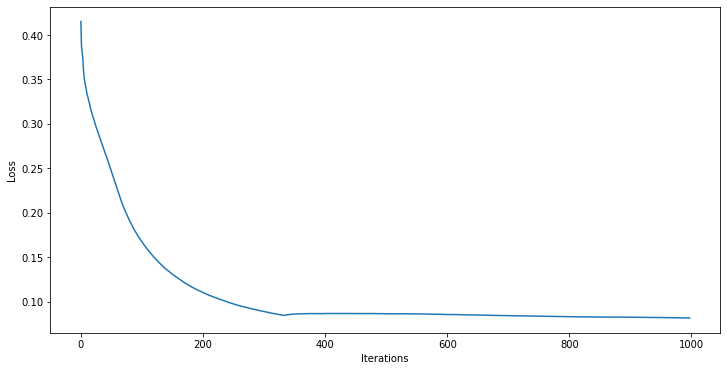

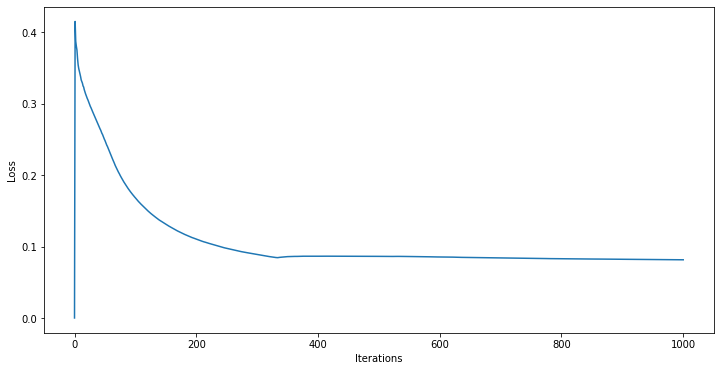

In [ ]:
for learning_rate in [1e-3, 1e-2]:
  enc_dec = Encoder_Decoder(len(hin_v2i), 256, len(eng_v2i))
  loss = setup(enc_dec, LEARNING_RATE=learning_rate, NUM_BATCHES=1000, BATCH_SIZE=64, DISPLAY_STEP=10, device=DEVICE, e=256)

Iteration 999 Loss 0.22062978148460388


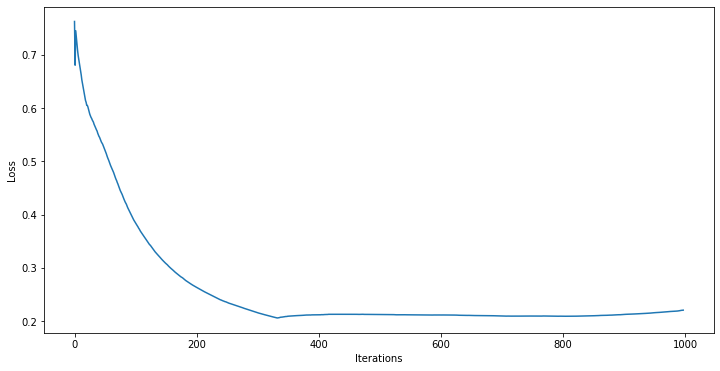

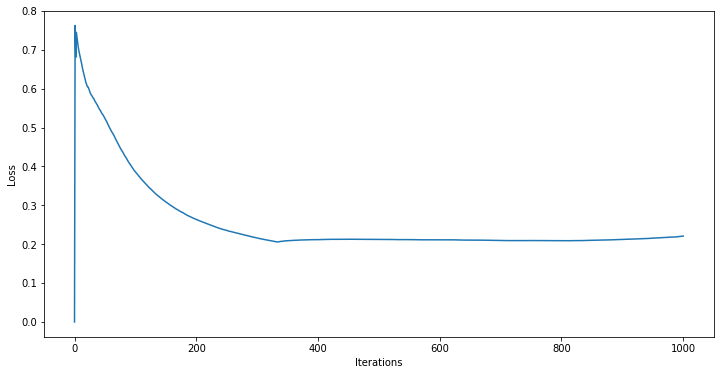

In [ ]:
for learning_rate in [1e-3, 1e-2]:
  enc_dec = Encoder_Decoder(len(hin_v2i), 256, len(eng_v2i))
  loss = setup(enc_dec, LEARNING_RATE=learning_rate, NUM_BATCHES=1000, BATCH_SIZE=32, DISPLAY_STEP=10, device=DEVICE, e=256)

# Testing and Inference

In [ ]:
def test(model, word, device='cpu'):
  model = model.eval().to(device)
  outputs = get_output(model, word, 30, device)
  eng_output = ''
  for output in outputs:
    values, indices = output.topk(1)
    idx = indices.tolist()[0][0]
    if idx == 0: # <PAD>
      break
    char = eng_i2v[idx]
    eng_output += char
  print(word, '->', eng_output)
  return eng_output

In [ ]:
def accuracy(model, device='cpu'):
  model = model.eval().to(device)
  preds = []
  acc = 0
  for i in range(len(test_data)):
    hindi, english = test_data[i]
    eng_ = eng_encoding(english, eng_v2i, device)
    outputs = get_output(model, hindi, eng_.shape[0], device)
    predicted_correctly = 0
    for i, output in enumerate(outputs):
      values, indices = output.topk(1)
      eng_pos = indices.tolist()[0]
      if eng_pos[0] == eng_[i][0]:
        predicted_correctly += 1

    acc += predicted_correctly / eng_.shape[0]
  acc /= len(test_data)
  return acc

## Loading all 5 models

### First model

In [ ]:
# batch size = 64, batches = 1000, learning rate = 1e-3, embedding size = 256
m1 = torch.load('models/lr=0.001-nb=1000-bs=64-e=256.pt')
print("Batch Size = 64, Batches = 1000, Learning rate = 1e-3, Embedding dimension = 256")
print("Accuracy:", accuracy(m1)*100)

In [ ]:
print("Output on a random sample:")
hin, eng = test_data.get_random_sample()
eng_out = test(m1, hin)
print("Actual:", eng, "\nPredicted:", eng_out)

Output on a random sample:
जलूँ -> jaluu
Actual: jaloon 
Predicted: jaluu


### Second Model

In [ ]:
# batch size = 64, batches = 1000, learning rate = 1e-2, embedding size = 256
m2 = torch.load('models/lr=0.01-nb=1000-bs=64-e=256.pt')
print("Batch Size = 64, Batches = 1000, Learning rate = 1e-2, Embedding dimension = 256")
print("Accuracy:", accuracy(m2)*100)

Batch Size = 64, Batches = 1000, Learning rate = 1e-2, Embedding dimension = 256
Accuracy: 76.40187387943642


In [ ]:
print("Output on a random sample:")
hin, eng = test_data.get_random_sample()
eng_out = test(m2, hin)
print("Actual:", eng, "\nPredicted:", eng_out)

Output on a random sample:
शरारा -> sharaara
Actual: sharara 
Predicted: sharaara


### Third model

In [ ]:
# batch size = 128, batches = 1000, learning rate = 1e-3, embedding size = 256
m3 = torch.load('models/lr=0.001-nb=1000-bs=128-e=256.pt')
print("Batch Size = 128, Batches = 1000, Learning rate = 1e-3, Embedding dimension = 256")
print("Accuracy:", accuracy(m3)*100)

Batch Size = 128, Batches = 1000, Learning rate = 1e-3, Embedding dimension = 256
Accuracy: 11.02938313848791


In [ ]:
print("Output on a random sample:")
hin, eng = test_data.get_random_sample()
eng_out = test(m3, hin)
print("Actual:", eng, "\nPredicted:", eng_out)

Output on a random sample:
गरूर -> fjjjj
Actual: goroor 
Predicted: fjjjj


### Fourth model

In [ ]:
# batch size = 32, batches = 1000, learning rate = 1e-3, embedding size = 256
m4 = torch.load('models/lr=0.001-nb=1000-bs=32-e=256.pt')
print("Batch Size = 32, Batches = 1000, Learning rate = 1e-3, Embedding dimension = 256")
print("Accuracy:", accuracy(m4)*100)

Batch Size = 32, Batches = 1000, Learning rate = 1e-3, Embedding dimension = 256
Accuracy: 78.04447420850961


In [ ]:
print("Output on a random sample:")
hin, eng = test_data.get_random_sample()
eng_out = test(m4, hin)
print("Actual:", eng, "\nPredicted:", eng_out)

Output on a random sample:
नीम्बू -> nimboo
Actual: nimbu 
Predicted: nimboo


### Fifth Model

In [ ]:
# batch size = 32, batches = 1000, learning rate = 1e-2, embedding size = 256
m5 = torch.load('models/lr=0.01-nb=1000-bs=32-e=256.pt')
print("Batch Size = 32, Batches = 1000, Learning rate = 1e-2, Embedding dimension = 256")
print("Accuracy:", accuracy(m5)*100)

Batch Size = 32, Batches = 1000, Learning rate = 1e-2, Embedding dimension = 256
Accuracy: 54.8670116227967


In [ ]:
print("Output on a random sample:")
hin, eng = test_data.get_random_sample()
eng_out = test(m5, hin)
print("Actual:", eng, "\nPredicted:", eng_out)

Output on a random sample:
चढ़ा -> chaha
Actual: chadhaa 
Predicted: chaha


# Metrics